In [ ]:
 !pip install -q google-generativeai

In [ ]:
!pip install -q google-genai pandas faiss-cpu numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 85.7 MB/s eta 0:00:00


In [ ]:
from google.api_core import timeout
# Importing Libraries
import google.generativeai as genai
from google.colab import userdata
import time
import pandas as pd
import json
import numpy as np
import faiss
# from google import genai

In [ ]:
api_key = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=api_key)

# Initialize the model
model = genai.GenerativeModel('models/gemini-2.5-pro')



In [ ]:


import json
import time
import random
from typing import Dict, List
import pandas as pd


class SingleLLMBaseline:
    """
    Single LLM approach - improves user story in ONE API call
    Compatible with Gemini 2.5 Pro or other GenAI models
    """

    def __init__(self, model, max_retries: int = 3, base_delay: float = 30.0):

        self.model = model
        self.model_name = "gemini-2.5-pro"
        self.max_retries = max_retries
        self.base_delay = base_delay

        # --- SYSTEM INSTRUCTION ---
        self.system_instruction = """You are an expert in user story quality improvement for Adobe Experience Manager (AEM) projects.

Your task: Improve the given user story to maximize INVEST quality and AEM best practices.

You must consider THREE perspectives in ONE response:
1. Product Owner: Business value, user needs, clarity
2. Developer: Technical feasibility, AEM implementation (HTL, Dispatcher, caching)
3. QA: Testability, clear acceptance criteria, compliance

INVEST Principles:
- Independent
- Negotiable
- Valuable
- Estimable
- Small
- Testable

AEM-Specific Requirements:
- Use HTL (not JSP) with context-aware escaping
- Apply Dispatcher caching strategies
- Mention performance metrics (e.g., "< 2s load time")
- Include security considerations
- Reference AEM Core Components where applicable

Output ONLY valid JSON in this exact format:
{
  "story": "Improved story in 'As a [user], I want [goal], so that [benefit]' format",
  "acceptance_criteria": [
    "Specific, measurable AC",
    "Include technical details and testability"
  ],
  "risks": ["Risk 1", "Risk 2"],
  "open_questions": ["Question 1"],
  "invest_assessment": {
    "independent": 4,
    "negotiable": 5,
    "valuable": 4,
    "estimable": 3,
    "small": 4,
    "testable": 5
  },
  "rationale": "Brief explanation of improvements made"
}"""



    def process_story(self, story: Dict) -> Dict:
        """Process a single story with automatic retry/backoff"""
        start_time = time.time()
        prompt = self._build_prompt(story)

        for attempt in range(1, self.max_retries + 1):
            try:
                response = self.model.generate_content(prompt)
                result = self._parse_json(response.text)
                result['processing_time'] = time.time() - start_time
                result['model_used'] = self.model_name
                result['iterations'] = 1
                result['approach'] = 'single_llm'
                result['original_story'] = story
                return result

            except Exception as e:
                msg = str(e)
                if "429" in msg or "quota" in msg.lower() or "503" in msg:
                    wait_time = self.base_delay * attempt + random.uniform(1, 10)
                    print(f"⚠️  Rate limit hit (attempt {attempt}/{self.max_retries}). Waiting {wait_time:.1f}s...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"❌ Error: {e}")
                    return {
                        "error": str(e),
                        "original_story": story,
                        "processing_time": time.time() - start_time,
                        "approach": "single_llm"
                    }

        # If all retries failed
        print(f"❌ All retries failed for story '{story.get('title', 'Unknown')}'")
        return {
            "error": "Exceeded retry limit",
            "original_story": story,
            "processing_time": time.time() - start_time,
            "approach": "single_llm"
        }


    def _build_prompt(self, story: Dict) -> str:
        acs = story.get("acceptance_criteria")
        if isinstance(acs, list):
            acs_formatted = "\n".join([f"- {a}" for a in acs])
        elif isinstance(acs, str):
            acs_formatted = "\n".join([f"- {a.strip()}" for a in acs.split("|")])
        else:
            acs_formatted = "None provided"

        return f"""{self.system_instruction}

USER STORY TO IMPROVE:
Title: {story.get('title', 'Untitled')}
Description: {story.get('description', 'No description')}
Current Acceptance Criteria:
{acs_formatted}
Domain/Tags: {story.get('domain', story.get('tags', 'general'))}

Please improve this user story following the INVEST and AEM guidelines.
Output ONLY the JSON (no markdown)."""


    def _parse_json(self, text: str) -> Dict:
        text = text.strip()
        if text.startswith("```json"):
            text = text[7:]
        elif text.startswith("```"):
            text = text[3:]
        if text.endswith("```"):
            text = text[:-3]

        start = text.find("{")
        end = text.rfind("}") + 1
        if start == -1 or end == 0:
            raise ValueError("No JSON found in response")

        json_str = text[start:end]
        return json.loads(json_str)

    def process_multiple_stories(self, stories: List[Dict], delay: float = 35.0) -> List[Dict]:
        results = []
        total = len(stories)

        print(f"\n{'='*70}")
        print(f"🎯 SINGLE LLM BASELINE - Processing {total} stories")
        print(f"{'='*70}\n")

        for i, story in enumerate(stories, 1):
            print(f"[{i}/{total}] Processing: {story.get('title', 'Untitled')}")
            result = self.process_story(story)
            results.append(result)

            if 'error' not in result:
                invest = result.get("invest_assessment", {})
                if invest:
                    avg = sum(invest.values()) / len(invest)
                    print(f"  ✓ INVEST avg: {avg:.2f}/5 | Time: {result['processing_time']:.2f}s")
                else:
                    print(f"  ✓ Processed in {result['processing_time']:.2f}s")
            else:
                print(f"  ✗ Error: {result['error']}")

            if i < total:
                print(f"  ⏳ Waiting {delay}s for rate limit...")
                time.sleep(delay + random.uniform(1, 5))
            print()

        print(f"{'='*70}\n✅ COMPLETED - Single LLM Run Finished\n{'='*70}")
        return results


    def save_results(self, results: List[Dict], filename: str = "single_llm_results.csv"):
        flattened = []
        for r in results:
            if "error" in r:
                flattened.append({
                    "approach": "single_llm",
                    "original_title": r.get("original_story", {}).get("title", "Unknown"),
                    "error": r["error"],
                    "processing_time": r.get("processing_time", 0)
                })
            else:
                inv = r.get("invest_assessment", {})
                avg = sum(inv.values()) / len(inv) if inv else 0
                flattened.append({
                    "approach": "single_llm",
                    "original_title": r["original_story"]["title"],
                    "improved_story": r["story"],
                    "acceptance_criteria": " | ".join(r.get("acceptance_criteria", [])),
                    "risks": " | ".join(r.get("risks", [])),
                    "open_questions": " | ".join(r.get("open_questions", [])),
                    "invest_average": avg,
                    "processing_time": r["processing_time"],
                    "rationale": r.get("rationale", "")
                })

        df = pd.DataFrame(flattened)
        df.to_csv(filename, index=False)
        print(f"\n💾 Results saved to: {filename}")
        return df





In [ ]:

df = pd.read_csv("./user_stories.csv")

print("Loaded stories:", df.shape)
df.head()

stories_to_process = []

for _, row in df.head(3).iterrows():
    # acceptance criteria in your dataset use " | " separator
    if isinstance(row["acceptance_criteria"], str):
        ac_list = [ac.strip() for ac in row["acceptance_criteria"].split("|") if ac.strip()]
    else:
        ac_list = []

    story_dict = {
        "title": row["title"],
        "description": row["description"],
        "acceptance_criteria": ac_list,
        "domain": row.get("domain", ""),
        "tags": row.get("tags", "")
    }

    stories_to_process.append(story_dict)

print("\nPrepared 3 stories for processing:")
for s in stories_to_process:
    print(" -", s["title"])


baseline = SingleLLMBaseline(model)


print("\n🟦 Running Single LLM Baseline on 3 stories...\n")

results = baseline.process_multiple_stories(stories_to_process, delay=3.0)


print("\n====================== RESULTS ======================\n")

for idx, r in enumerate(results, start=1):
    print(f"\n---------------- Story {idx} ----------------")

    if "error" in r:
        print("❌ ERROR:", r["error"])
        continue

    print("\n✨ Improved Story:")
    print(r["story"])

    print("\n📌 Acceptance Criteria:")
    for ac in r.get("acceptance_criteria", []):
        print(" -", ac)

    print("\n⚠️ Risks:")
    for risk in r.get("risks", []):
        print(" -", risk)

    print("\n❓ Open Questions:")
    for q in r.get("open_questions", []):
        print(" -", q)

    print("\nINVEST Assessment:", r.get("invest_assessment", {}))

    print("\n⏱ Processing Time:", r.get("processing_time", 0), "sec")

print("\n=====================================================\n")


Loaded stories: (90, 12)

Prepared 3 stories for processing:
 - Implement GraphQL APIs to enhance performance
 - Configure Core Components to enable headless publishing
 - Configure JSON Exporter to improve author efficiency

🟦 Running Single LLM Baseline on 3 stories...


🎯 SINGLE LLM BASELINE - Processing 3 stories

[1/3] Processing: Implement GraphQL APIs to enhance performance
  ✓ INVEST avg: 4.50/5 | Time: 30.57s
  ⏳ Waiting 3.0s for rate limit...

[2/3] Processing: Configure Core Components to enable headless publishing
  ✓ INVEST avg: 4.33/5 | Time: 25.99s
  ⏳ Waiting 3.0s for rate limit...

[3/3] Processing: Configure JSON Exporter to improve author efficiency
  ✓ INVEST avg: 4.33/5 | Time: 31.62s

✅ COMPLETED - Single LLM Run Finished

====================== RESULTS ======================


---------------- Story 1 ----------------

✨ Improved Story:
As a mobile app user, I want to view a list of articles with their title, summary, and author, so that I can quickly browse the 

In [ ]:
#Graph RAG
import pandas as pd
import numpy as np
import faiss
from google import genai

# Configure your API key
API_KEY = "GEMINI_API_KEY"
client = genai.Client(api_key=API_KEY)

# Load policies
policies_df = pd.read_csv("./policies.csv")
policy_texts = policies_df["clause_text"].astype(str).tolist()
policy_ids = policies_df["policy_id"].tolist()  # ensure this column exists

def embed(texts):
    resp = client.models.embed_content(
        model="gemini-embedding-001",
        contents=texts
    )
    embeddings = [np.array(embed.values, dtype=np.float32) for embed in resp.embeddings]
    return np.vstack(embeddings)

policy_embeddings = embed(policy_texts)
policy_embeddings_norm = policy_embeddings / np.linalg.norm(policy_embeddings, axis=1, keepdims=True)

index = faiss.IndexFlatIP(policy_embeddings_norm.shape[1])
index.add(policy_embeddings_norm)

def retrieve_policies(query, k=6):
    q = embed([query])[0]
    q = q / np.linalg.norm(q)
    D, I = index.search(q.reshape(1, -1), k)
    out = []
    for idx, score in zip(I[0], D[0]):
        out.append({
            "policy_id": policy_ids[idx],
            "clause_text": policy_texts[idx],
            "score": float(score)
        })
    return out


In [ ]:
#Multi agent without Graph RAG

import json
import time
import random
import pandas as pd

class MultiAgentLLM:
    """
    Multi-Agent LLM pipeline (PO → DEV → QA)
    No embeddings, Gemini Free Tier compatible
    ARM A output style
    """

    def __init__(self, model, max_retries=3, base_delay=30.0):
        self.model = model
        self.max_retries = max_retries
        self.base_delay = base_delay
        self.model_name = "gemini-2.5-pro"

    # -----------------------------
    # JSON extractor
    # -----------------------------
    def _extract_json(self, text):
        text = text.strip().replace("```json", "").replace("```", "")
        start = text.find("{")
        end = text.rfind("}") + 1
        if start == -1:
            raise ValueError("No JSON object found")
        return json.loads(text[start:end])

    # -----------------------------
    # Gemini call with timeout + retries
    # -----------------------------
    def _ask(self, prompt):
        for attempt in range(1, self.max_retries + 1):
            try:
                resp = self.model.generate_content(
                    prompt,
                    request_options={"timeout": 60}  # timeout fix
                )
                return self._extract_json(resp.text)

            except Exception as e:
                msg = str(e)

                if "timed out" in msg or "ReadTimeout" in msg:
                    wait = self.base_delay * attempt + random.uniform(1, 5)
                    print(f"⏳ Timeout. Retrying in {wait:.1f}s...")
                    time.sleep(wait)
                    continue

                if "429" in msg or "quota" in msg.lower() or "503" in msg:
                    wait = self.base_delay * attempt + random.uniform(1, 5)
                    print(f"⚠️ Rate limit. Waiting {wait:.1f}s...")
                    time.sleep(wait)
                    continue

                # If other error, return fallback but don't crash
                return {
                    "story": {"title": "ERROR", "description": ""},
                    "acceptance_criteria": [],
                    "risks": [],
                    "open_questions": [],
                    "qa_notes": [],
                    "error": str(e)
                }

        # exceeded retries
        return {
            "story": {"title": "ERROR", "description": ""},
            "acceptance_criteria": [],
            "risks": [],
            "open_questions": [],
            "qa_notes": [],
            "error": "Exceeded retry attempts"
        }

    # -----------------------------
    # Product Owner Agent
    # -----------------------------
    def agent_po(self, story):
        ac = story["acceptance_criteria"]
        ac_text = "\n".join(f"- {a}" for a in ac)

        prompt = f"""
You are a Product Owner improving a user story.

Return ONLY JSON:
{{
  "story": {{"title":"...", "description":"..."}},
  "acceptance_criteria": ["..."],
  "open_questions": ["..."]
}}

TITLE: {story["title"]}
DESC: {story["description"]}
AC:
{ac_text}
"""
        return self._ask(prompt)

    # -----------------------------
    # Developer Agent
    # -----------------------------
    def agent_dev(self, po_out):
        ac = po_out["acceptance_criteria"]
        ac_text = "\n".join(f"- {a}" for a in ac)

        prompt = f"""
You are an AEM Developer. Improve technical detail and add risks.

Return ONLY JSON:
{{
  "story": {{"title":"...", "description":"..."}},
  "acceptance_criteria": ["..."],
  "risks": ["..."]
}}

PO STORY:
{po_out["story"]}

AC:
{ac_text}
"""
        return self._ask(prompt)

    # -----------------------------
    # QA Agent
    # -----------------------------
    def agent_qa(self, dev_out):
        ac = dev_out["acceptance_criteria"]
        ac_text = "\n".join(f"- {a}" for a in ac)

        prompt = f"""
You are QA. Ensure clarity and testability.

Return ONLY JSON:
{{
  "story": {{"title":"...", "description":"..."}},
  "acceptance_criteria": ["..."],
  "qa_notes": ["..."]
}}

DEV STORY:
{dev_out["story"]}

AC:
{ac_text}
"""
        return self._ask(prompt)

    # -----------------------------
    # MAIN PROCESSOR
    # -----------------------------
    def process_story(self, story):
        start = time.time()

        po = self.agent_po(story)
        dev = self.agent_dev(po)
        qa = self.agent_qa(dev)

        return {
            "approach": "multi_llm",
            "original_title": story["title"],
            "story": qa["story"],
            "acceptance_criteria": qa["acceptance_criteria"],
            "risks": dev.get("risks", []),
            "open_questions": po.get("open_questions", []),
            "qa_notes": qa.get("qa_notes", []),
            "processing_time": time.time() - start,
            "model_used": self.model_name,
            "original_story": story
        }

    # -----------------------------
    # BATCH PROCESSOR (matching ARM A)
    # -----------------------------
    def process_multiple_stories(self, stories, delay=0):
        results = []
        for s in stories:
            results.append(self.process_story(s))
            if delay > 0:
                time.sleep(delay)
        return results

    # -----------------------------
    # SAVE RESULTS LIKE ARM A
    # -----------------------------
    def save_results(self, results, filename="arm_b_results.csv"):
        rows = []
        for r in results:
            rows.append({
                "approach": r["approach"],
                "original_title": r["original_title"],
                "improved_story": r["story"],
                "acceptance_criteria": " | ".join(r["acceptance_criteria"]),
                "risks": " | ".join(r["risks"]),
                "open_questions": " | ".join(r["open_questions"]),
                "qa_notes": " | ".join(r["qa_notes"]),
                "processing_time": r["processing_time"],
            })

        df = pd.DataFrame(rows)
        df.to_csv(filename, index=False)
        print("💾 Saved:", filename)
        return df


In [ ]:
stories_df = pd.read_csv("./user_stories.csv")

stories = []
for _, r in stories_df.head(3).iterrows():
    ac_list = [ac.strip() for ac in r["acceptance_criteria"].split("|")]

    stories.append({
        "title": r["title"],
        "description": r["description"],
        "acceptance_criteria": ac_list,
        "domain": r.get("domain", "")
    })


In [ ]:
multi = MultiAgentLLM(model)
results_b = multi.process_multiple_stories(stories, delay=3)


In [ ]:
import json
print(json.dumps(results_b, indent=2, ensure_ascii=False))


[
  {
    "approach": "multi_llm",
    "original_title": "Implement GraphQL APIs to enhance performance",
    "story": {
      "title": "Enable GraphQL Persisted Query for the 'Article' Content Fragment Model",
      "description": "As a front-end developer, I need a secure and performant AEM GraphQL persisted query to retrieve specific fields from an 'Article' Content Fragment, so that I can efficiently populate an article details page by fetching only the necessary data and leveraging CDN/Dispatcher caching."
    },
    "acceptance_criteria": [
      "Given the AEM GraphQL endpoint is configured for the project, when the configuration is checked, then the 'Article' Content Fragment Model must be enabled.",
      "A persisted GraphQL query (e.g., `my-project/article-by-path`) must be created that fetches a single Article Content Fragment.",
      "The persisted query must accept two variables: `articlePath` (String, e.g., '/content/dam/my-project/articles/my-first-article') and `local

In [ ]:
# import json
# import time
# import random
# import pandas as pd

# class MultiAgentLLM_RAG:
#     """
#     Multi-Agent LLM pipeline with RAG (PO → DEV → QA)
#     Uses FAISS/embedding retrieval to provide context
#     """

#     def __init__(self, model, retrieve_fn, top_k=3, max_retries=3, base_delay=30.0):
#         self.model = model
#         self.retrieve_fn = retrieve_fn
#         self.top_k = top_k
#         self.max_retries = max_retries
#         self.base_delay = base_delay
#         self.model_name = "gemini-2.5-pro"

#     def _extract_json(self, text):
#         text = text.strip().replace("```json", "").replace("```", "")
#         start = text.find("{")
#         end = text.rfind("}") + 1
#         if start == -1:
#             raise ValueError("No JSON object found")
#         return json.loads(text[start:end])

#     def _ask(self, prompt):
#         for attempt in range(1, self.max_retries + 1):
#             try:
#                 resp = self.model.generate_content(prompt, request_options={"timeout": 60})
#                 return self._extract_json(resp.text)
#             except Exception as e:
#                 msg = str(e)
#                 if "timed out" in msg or "ReadTimeout" in msg:
#                     wait = self.base_delay * attempt + random.uniform(1,5)
#                     time.sleep(wait)
#                     continue
#                 if "429" in msg or "quota" in msg.lower() or "503" in msg:
#                     wait = self.base_delay * attempt + random.uniform(1,5)
#                     time.sleep(wait)
#                     continue
#                 return {
#                     "story": {"title":"ERROR","description":""},
#                     "acceptance_criteria": [],
#                     "risks": [],
#                     "open_questions": [],
#                     "qa_notes": [],
#                     "error": str(e)
#                 }
#         return {
#             "story": {"title":"ERROR","description":""},
#             "acceptance_criteria": [],
#             "risks": [],
#             "open_questions": [],
#             "qa_notes": [],
#             "error": "Exceeded retry attempts"
#         }

#     def _get_context_text(self, story):
#       description = story.get("description", "")
#       if not description.strip():
#           description = "No story description provided."
#       retrieved = self.retrieve_fn(description, self.top_k)
#       if not retrieved or all(not r.get("clause_text","").strip() for r in retrieved):
#           return "No relevant policy context available."
#       return "\n".join([r["clause_text"] for r in retrieved])


#     def agent_po(self, story):
#       query = story["description"]
#       retrieved = retrieve_policies(query, k=3)  # returns list of dicts

#       if not retrieved:
#           retrieved_text = "No relevant policies found."
#       else:
#           retrieved_text = "\n".join([r["clause_text"] for r in retrieved])

#       ac_text = "\n".join(f"- {a}" for a in story["acceptance_criteria"])

#       prompt = f"""
#   You are a Product Owner improving a user story. Use the retrieved policies to enhance it.

#   Retrieved Policies:
#   {retrieved_text}

#   Return ONLY JSON:
#   {{
#     "story": {{"title":"...", "description":"..."}},
#     "acceptance_criteria": ["..."],
#     "open_questions": ["..."]
#   }}

#   TITLE: {story["title"]}
#   DESC: {story["description"]}
#   AC:
#   {ac_text}
#   """
#       return self._ask(prompt)


#     def agent_dev(self, po_out):
#         ac_text = "\n".join(f"- {a}" for a in po_out["acceptance_criteria"])
#         retrieved_text = self._get_context_text(po_out["story"])

#         prompt = f"""
# You are an AEM Developer. Improve technical detail and add risks.

# Context policies:
# {retrieved_text}

# Return ONLY JSON:
# {{
#   "story": {{"title":"...", "description":"..."}},
#   "acceptance_criteria": ["..."],
#   "risks": ["..."]
# }}

# PO STORY:
# {po_out["story"]}

# AC:
# {ac_text}
# """
#         return self._ask(prompt)

#     def agent_qa(self, dev_out):
#         ac_text = "\n".join(f"- {a}" for a in dev_out["acceptance_criteria"])
#         retrieved_text = self._get_context_text(dev_out["story"])

#         prompt = f"""
# You are QA. Ensure clarity and testability.

# Context policies:
# {retrieved_text}

# Return ONLY JSON:
# {{
#   "story": {{"title":"...", "description":"..."}},
#   "acceptance_criteria": ["..."],
#   "qa_notes": ["..."]
# }}

# DEV STORY:
# {dev_out["story"]}

# AC:
# {ac_text}
# """
#         return self._ask(prompt)

#     def process_story(self, story):
#         start = time.time()
#         po = self.agent_po(story)
#         dev = self.agent_dev(po)
#         qa = self.agent_qa(dev)

#         return {
#             "approach": "multi_llm_rag",
#             "original_title": story["title"],
#             "story": qa["story"],
#             "acceptance_criteria": qa["acceptance_criteria"],
#             "risks": dev.get("risks", []),
#             "open_questions": po.get("open_questions", []),
#             "qa_notes": qa.get("qa_notes", []),
#             "processing_time": time.time() - start,
#             "model_used": self.model_name,
#             "original_story": story
#         }

#     def process_multiple_stories(self, stories, delay=0):
#         results = []
#         for s in stories:
#             results.append(self.process_story(s))
#             if delay > 0:
#                 time.sleep(delay)
#         return results

#     def save_results(self, results, filename="multi_agent_rag_results.csv"):
#         rows = []
#         for r in results:
#             rows.append({
#                 "approach": r["approach"],
#                 "original_title": r["original_title"],
#                 "improved_story": r["story"],
#                 "acceptance_criteria": " | ".join(r["acceptance_criteria"]),
#                 "risks": " | ".join(r["risks"]),
#                 "open_questions": " | ".join(r["open_questions"]),
#                 "qa_notes": " | ".join(r["qa_notes"]),
#                 "processing_time": r["processing_time"],
#             })
#         df = pd.DataFrame(rows)
#         df.to_csv(filename, index=False)
#         print("💾 Saved:", filename)
#         return df


In [ ]:
# stories_df = pd.read_csv("./user_stories.csv")

# stories = []
# for _, r in stories_df.head(3).iterrows():
#     ac_list = [ac.strip() for ac in r["acceptance_criteria"].split("|")]
#     stories.append({
#         "title": r["title"],
#         "description": r["description"],
#         "acceptance_criteria": ac_list,
#         "domain": r.get("domain", "")
#     })

# multi_rag = MultiAgentLLM_RAG(
#     model=genai,                # your Gemini client
#     retrieve_fn=retrieve_policies,
#     top_k=3
# )

# results_rag = multi_rag.process_multiple_stories(stories, delay=3)
# df_rag = multi_rag.save_results(results_rag)
# import json
# print(json.dumps(results_rag, indent=2, ensure_ascii=False))


💾 Saved: multi_agent_rag_results.csv
[
  {
    "approach": "multi_llm_rag",
    "original_title": "Implement GraphQL APIs to enhance performance",
    "story": {
      "title": "ERROR",
      "description": ""
    },
    "acceptance_criteria": [],
    "risks": [],
    "open_questions": [],
    "qa_notes": [],
    "processing_time": 0.6409657001495361,
    "model_used": "gemini-2.5-pro",
    "original_story": {
      "title": "Implement GraphQL APIs to enhance performance",
      "description": "As an AEM headless developer, I want to implement GraphQL APIs to enhance performance, so that the solution aligns with AEM Cloud Service best practices.",
      "acceptance_criteria": [
        "GraphQL schema changes must be versioned and documented.",
        "APIs must support localized content variants.",
        "Content Fragment Models must define explicit data types for all fields."
      ],
      "domain": "headless"
    }
  },
  {
    "approach": "multi_llm_rag",
    "original_title": 


🎯 SINGLE LLM BASELINE - Processing 3 stories

[1/3] Processing: Implement GraphQL APIs to enhance performance
  ✓ INVEST avg: 4.33/5 | Time: 30.17s
  ⏳ Waiting 0s for rate limit...

[2/3] Processing: Configure Core Components to enable headless publishing
  ✓ INVEST avg: 4.83/5 | Time: 25.98s
  ⏳ Waiting 0s for rate limit...

[3/3] Processing: Configure JSON Exporter to improve author efficiency
  ✓ INVEST avg: 4.17/5 | Time: 27.12s

✅ COMPLETED - Single LLM Run Finished
           ARM A     ARM B
Precision    1.0  1.000000
Recall       1.0  0.333333
F1           1.0  0.500000
Accuracy     1.0  0.333333


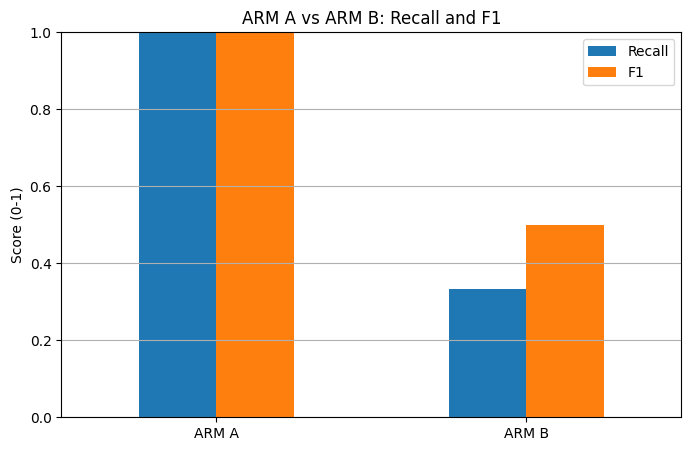

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_A = baseline.process_multiple_stories(stories_to_process, delay=0)
results_B = multi.process_multiple_stories(stories_to_process, delay=0)

def avg_invest_score(r):
    inv = r.get("invest_assessment")
    if isinstance(inv, dict) and len(inv)>0:
        vals = [v for v in inv.values() if isinstance(v, (int,float))]
        return float(np.mean(vals)) if vals else np.nan
    return np.nan

def proxy_score_from_fields(r):
    ac = r.get("acceptance_criteria") or []
    risks = r.get("risks") or []
    oq = r.get("open_questions") or []
    qa = r.get("qa_notes") or []
    scores = {
        "ac_count": len(ac),
        "risks_count": len(risks),
        "oq_count": len(oq),
        "qa_count": len(qa) if isinstance(qa, list) else (1 if qa else 0)
    }
    return scores

A_scores = []
B_scores = []
A_ac_counts = []
B_ac_counts = []
A_risk_counts = []
B_risk_counts = []
A_oq = []
B_oq = []
A_qa = []
B_qa = []

for ra, rb in zip(results_A, results_B):
    A_scores.append(avg_invest_score(ra))
    B_scores.append(np.nan)  # placeholder
    a_fields = proxy_score_from_fields(ra)
    b_fields = proxy_score_from_fields(rb)
    A_ac_counts.append(a_fields["ac_count"])
    B_ac_counts.append(b_fields["ac_count"])
    A_risk_counts.append(a_fields["risks_count"])
    B_risk_counts.append(b_fields["risks_count"])
    A_oq.append(a_fields["oq_count"])
    B_oq.append(b_fields["oq_count"])
    A_qa.append(a_fields["qa_count"])
    B_qa.append(b_fields["qa_count"])

all_ac = np.array(A_ac_counts + B_ac_counts, dtype=float)
all_risks = np.array(A_risk_counts + B_risk_counts, dtype=float)
all_oq = np.array(A_oq + B_oq, dtype=float)
all_qa = np.array(A_qa + B_qa, dtype=float)
max_ac = all_ac.max() if all_ac.max()>0 else 1.0
max_risks = all_risks.max() if all_risks.max()>0 else 1.0
max_oq = all_oq.max() if all_oq.max()>0 else 1.0
max_qa = all_qa.max() if all_qa.max()>0 else 1.0

def compute_proxy_score(ac, risks, oq, qa):
    a = (ac / max_ac)
    r = (1 - (risks / (max_risks)))  # fewer risks = better
    o = (1 - (oq / (max_oq)))        # fewer open questions = better
    q = (qa / max_qa)
    score = (0.45*a + 0.25*r + 0.15*o + 0.15*q) * 5.0
    return float(np.clip(score, 0, 5))

for i, rb in enumerate(results_B):
    B_scores[i] = compute_proxy_score(B_ac_counts[i], B_risk_counts[i], B_oq[i], B_qa[i])

for i, ra in enumerate(results_A):
    if np.isnan(A_scores[i]):
        A_scores[i] = compute_proxy_score(A_ac_counts[i], A_risk_counts[i], A_oq[i], A_qa[i])

A_scores = np.array(A_scores, dtype=float)
B_scores = np.array(B_scores, dtype=float)

threshold = 3.0
A_binary = (A_scores >= threshold).astype(int)
B_binary = (B_scores >= threshold).astype(int)
gt = np.ones_like(A_binary)

def prf(y_true, y_pred):
    tp = int(((y_pred==1) & (y_true==1)).sum())
    fp = int(((y_pred==1) & (y_true==0)).sum())
    fn = int(((y_pred==0) & (y_true==1)).sum())
    precision = tp / (tp+fp+1e-10)
    recall = tp / (tp+fn+1e-10)
    f1 = 2*precision*recall/(precision+recall+1e-10)
    acc = ((y_pred==y_true).sum())/len(y_true)
    return precision, recall, f1, acc

pA, rA, f1A, accA = prf(gt, A_binary)
pB, rB, f1B, accB = prf(gt, B_binary)

metrics_df = pd.DataFrame({
    "ARM A": [pA, rA, f1A, accA],
    "ARM B": [pB, rB, f1B, accB]
}, index=["Precision","Recall","F1","Accuracy"])

print(metrics_df)

metrics_df.loc[["Recall","F1"]].T.plot(kind="bar", figsize=(8,5))
plt.ylim(0,1)
plt.title("ARM A vs ARM B: Recall and F1")
plt.ylabel("Score (0-1)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()
